In [1]:
import qlib
from qlib.constant import REG_CN
data_uri = '~/.qlib/qlib_data/cn_data/'
qlib.init(provider_uri=data_uri, region=REG_CN)
from qlib.data.dataset.handler import DataHandlerLP

# 使用"配置"进行实例化
from qlib.utils import init_instance_by_config
from qlib.contrib.data.handler import Alpha158
from qlib.data.dataset import TSDatasetH
from qlib.contrib.model.pytorch_alstm_ts import ALSTM

# 配置数据
train_period = ("2017-01-01", "2018-12-31")
valid_period = ("2019-01-01", "2019-12-31")
test_period = ("2020-01-01", "2020-08-01")

dh = Alpha158(instruments='csi300', 
              start_time=train_period[0], 
              end_time=test_period[1],
             fit_start_time = "2018-01-01",
             fit_end_time = "2019-12-31",
              infer_processors= [
                        {"class": "RobustZScoreNorm", "kwargs": {"fields_group": "feature", "clip_outlier": "true"}},
                        {"class": "Fillna", "kwargs": {"fields_group": "feature"}},
                    ],
            learn_processors= [
                        "DropnaLabel",
                        {"class": "CSRankNorm", "kwargs": {"fields_group": "label"}},  # CSRankNorm
                    ],
             )
ds = TSDatasetH(handler=dh,
                step_len=20, # 时间步数
                segments={"train": train_period, 
                          "valid": valid_period, 
                          "test": test_period})


[3601600:MainThread](2024-12-15 19:53:28,674) INFO - qlib.Initialization - [config.py:420] - default_conf: client.
[3601600:MainThread](2024-12-15 19:53:28,887) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[3601600:MainThread](2024-12-15 19:53:28,887) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/home/hhh/.qlib/qlib_data/cn_data')}


ModuleNotFoundError. CatBoostModel are skipped. (optional: maybe installing CatBoostModel can fix it.)
ModuleNotFoundError. XGBModel is skipped(optional: maybe installing xgboost can fix it).


/home/hhh/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[3601600:MainThread](2024-12-15 19:53:43,982) INFO - qlib.timer - [log.py:127] - Time cost: 13.583s | Loading data Done
/home/hhh/.local/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
[3601600:MainThread](2024-12-15 19:53:47,765) INFO - qlib.timer - [log.py:127] - Time cost: 3.698s | RobustZScoreNorm Done
[3601600:MainThread](2024-12-15 19:53:47,902) INFO - qlib.timer - [log.py:127] - Time cost: 0.136s | Fillna Done
[3601600:MainThread](2024-12-15 19:53:47,980) INFO - qlib.timer - [log.py:127] - Time cost: 0.050s | DropnaLabel Done
/home/hhh/miniconda3/envs/myModule/lib/python3.11/site-packages/qlib/data/dataset/pr

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
#%%
from qlib.data.dataset.handler import DataHandlerLP
dl_train = ds.prepare("train", col_set=["feature", "label"], data_key=DataHandlerLP.DK_L)
dl_valid = ds.prepare("valid", col_set=["feature", "label"], data_key=DataHandlerLP.DK_L)

dl_train.config(fillna_type="ffill+bfill")  # process nan brought by dataloader
dl_valid.config(fillna_type="ffill+bfill")

In [3]:
import numpy as np
import torch.nn as nn
import torch
import math
seed = 32
np.random.seed(seed) 
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)

train_loader = DataLoader(
dl_train, batch_size=5192, shuffle=True, num_workers=0, drop_last=True
)
valid_loader = DataLoader(
dl_valid, batch_size=5192, shuffle=True, num_workers=0, drop_last=True
)

Epoch 0
train 1.102622, valid 1.509614
Epoch 1
train 1.057971, valid 1.298217
Epoch 2
train 1.040887, valid 1.503150
Epoch 3
train 1.034133, valid 1.189618
Epoch 4
train 1.029072, valid 1.844866
Epoch 5
train 1.026484, valid 1.320875
Epoch 6
train 1.021960, valid 1.675927
Epoch 7
train 1.021513, valid 1.189604
Epoch 8
train 1.019238, valid 1.327516
Epoch 9
train 1.018718, valid 1.249582
Epoch 10
train 1.016556, valid 1.472861
Epoch 11
train 1.016545, valid 1.298970
Epoch 12
train 1.015905, valid 2.430757
Epoch 13
train 1.014346, valid 2.085375
Epoch 14
train 1.013438, valid 1.280744
Epoch 15
train 1.014361, valid 2.355410
Epoch 16
train 1.013261, valid 1.471952
Epoch 17
train 1.012881, valid 1.240915
Epoch 18
train 1.011643, valid 1.209588
Epoch 19
train 1.012077, valid 1.180252
Epoch 20
train 1.011301, valid 1.197152
Epoch 21
train 1.011338, valid 2.470756
Epoch 22
train 1.010974, valid 1.409614
Epoch 23
train 1.010380, valid 2.218814
Epoch 24
train 1.010385, valid 1.995189
Epoch 25
t

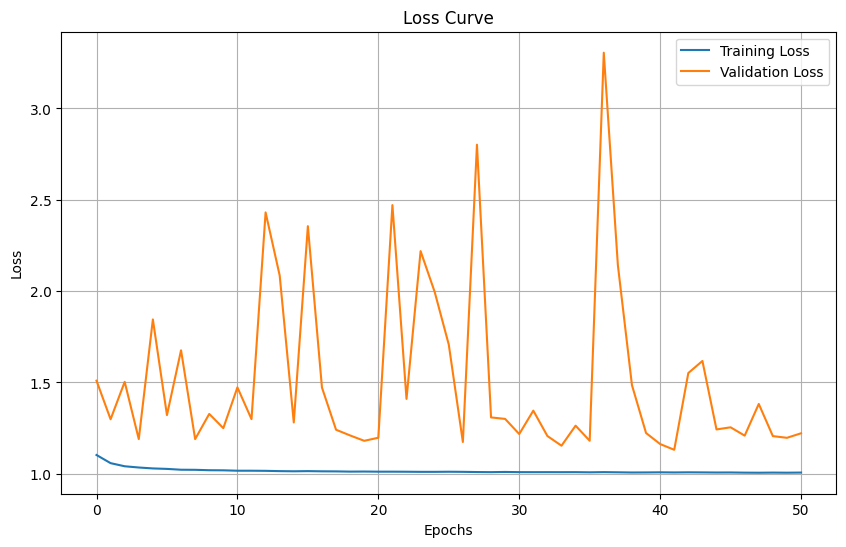

In [5]:
from torch.utils.tensorboard import SummaryWriter
from transformer import train_transformer, test_transformer,TransformerModule
import matplotlib.pyplot as plt

# 创建一个SummaryWriter对象*
writer = SummaryWriter('runs/my_experiment')

n_epochs = 51
train_losses = []
val_losses = []
model = TransformerModule()
for epoch in range(n_epochs):
    print("Epoch %d" % epoch)
    # train_transformer(train_loader, epoch)
    train_loss =train_transformer(train_loader, epoch, model)
    val_loss = test_transformer(valid_loader)
    writer.add_scalar('Train Loss', train_loss, epoch)
    print("train %.6f, valid %.6f" % (train_loss, val_loss))
    train_losses.append(train_loss)
    val_losses.append(val_loss)


# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()